<a href="https://www.kaggle.com/code/himanshuvaria/yield-prediction?scriptVersionId=160453482" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Introduction**

In the complex landscape of semiconductor manufacturing, monitoring signals and variables from sensor data is crucial. This Kaggle notebook explores the SECOM dataset, which encompasses a wide range of features representing different signals in the manufacturing process. The goal is to predict the yield outcome (pass/fail) of each product, using machine learning techniques to sift through the noise and identify key factors that contribute to yield excursions.

**Dataset Overview**

The SECOM dataset consists of 1567 examples, each with 591 features, and includes information on 104 failed cases. The features represent various signals and measurements in the semiconductor manufacturing process. This study aims to rank these features by their impact on yield, examining potential causal relationships to enhance predictability and reduce error rates.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yield-analyst/secom_labels.data
/kaggle/input/yield-analyst/secom.data


In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


**Data Loading**

In [3]:
# Paths to the dataset files
label_path = '/kaggle/input/yield-analyst/secom_labels.data'
data_path = '/kaggle/input/yield-analyst/secom.data'

# Load the data
data = pd.read_csv(data_path, sep=' ', header=None)
labels = pd.read_csv(label_path, sep=' ', header=None, usecols=[0])

**Data Inspection**

In [4]:
# Data Exploration
# Combine data and labels
data['Label'] = labels[0].astype(int).replace(-1, 0)

# Explore the dataset
print("Data Shape:", data.shape)
print("First 5 rows of the dataset:\n", data.head())
print("\nStatistics of the dataset:\n", data.describe())
print("\nMissing values in each column:\n", data.isnull().sum())
print("\nDistribution of labels:\n", data['Label'].value_counts())


Data Shape: (1567, 591)
First 5 rows of the dataset:
          0        1          2          3       4      5         6       7  \
0  3030.93  2564.00  2187.7333  1411.1265  1.3602  100.0   97.6133  0.1242   
1  3095.78  2465.14  2230.4222  1463.6606  0.8294  100.0  102.3433  0.1247   
2  2932.61  2559.94  2186.4111  1698.0172  1.5102  100.0   95.4878  0.1241   
3  2988.72  2479.90  2199.0333   909.7926  1.3204  100.0  104.2367  0.1217   
4  3032.24  2502.87  2233.3667  1326.5200  1.5334  100.0  100.3967  0.1235   

        8       9  ...       581     582     583     584      585     586  \
0  1.5005  0.0162  ...       NaN  0.5005  0.0118  0.0035   2.3630     NaN   
1  1.4966 -0.0005  ...  208.2045  0.5019  0.0223  0.0055   4.4447  0.0096   
2  1.4436  0.0041  ...   82.8602  0.4958  0.0157  0.0039   3.1745  0.0584   
3  1.4882 -0.0124  ...   73.8432  0.4990  0.0103  0.0025   2.0544  0.0202   
4  1.5031 -0.0031  ...       NaN  0.4800  0.4766  0.1045  99.3032  0.0202   

      587     

**Data Preprocessing**

This block prepares the data for modeling. It combines the data and labels, handles missing values by imputing them with the mean of each column, and scales the features using standardization (StandardScaler).

In [5]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_imputed = imputer.fit_transform(data.drop('Label', axis=1))

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

**Addressing Class Imbalance**

This block tackles the class imbalance issue using SMOTE (Synthetic Minority Over-sampling Technique).


In [6]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_scaled, data['Label'])

****Dimensionality Reduction**

PCA is applied here to reduce the dimensionality of the data while preserving 95% of the variance. It helps to reduce the computational cost and potential overfitting.

In [7]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_smote)

**Splitting the Data**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_smote, test_size=0.2, random_state=42)


**XGBoost Model Training and Evaluation**

In [9]:
xgb_model = XGBClassifier(tree_method='gpu_hist', scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)
print("XGBoost Model Performance")
print("Accuracy:", accuracy_score(y_test, xgb_predictions))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_predictions))
print("Classification Report:\n", classification_report(y_test, xgb_predictions))

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost Model Performance
Accuracy: 0.9948805460750854
ROC AUC Score: 0.9947945845004669
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       306
           1       1.00      0.99      0.99       280

    accuracy                           0.99       586
   macro avg       0.99      0.99      0.99       586
weighted avg       0.99      0.99      0.99       586



/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


**LightGBM Model Training and Evaluation**

In [10]:
lgb_model = lgb.LGBMClassifier(objective='binary')
lgb_model.fit(X_train, y_train)

lgb_predictions = lgb_model.predict(X_test)
print("LightGBM Model Performance")
print("Accuracy:", accuracy_score(y_test, lgb_predictions))
print("ROC AUC Score:", roc_auc_score(y_test, lgb_predictions))
print("Classification Report:\n", classification_report(y_test, lgb_predictions))

LightGBM Model Performance
Accuracy: 0.9914675767918089
ROC AUC Score: 0.991374883286648
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       306
           1       0.99      0.99      0.99       280

    accuracy                           0.99       586
   macro avg       0.99      0.99      0.99       586
weighted avg       0.99      0.99      0.99       586



**Cross Validation**

Cross-validation is conducted to assess the model's performance in a more robust manner.

In [11]:
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print("XGB - Mean AUC Score from Cross-Validation:", xgb_cv_scores.mean())

lbgm_cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print("LBGM - Mean AUC Score from Cross-Validation:", lbgm_cv_scores.mean())

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:42:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

XGB - Mean AUC Score from Cross-Validation: 0.9988237028554613
LBGM - Mean AUC Score from Cross-Validation: 0.9987469909935953


**Learning Curve**

To visualize the model's performance over varying amounts of training data. This helps in understanding whether the model benefits from more data (indicating underfitting) or if it has reached a plateau (indicating overfitting or optimal learning).



In [12]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
 
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    axes.legend(loc="best")

    return plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


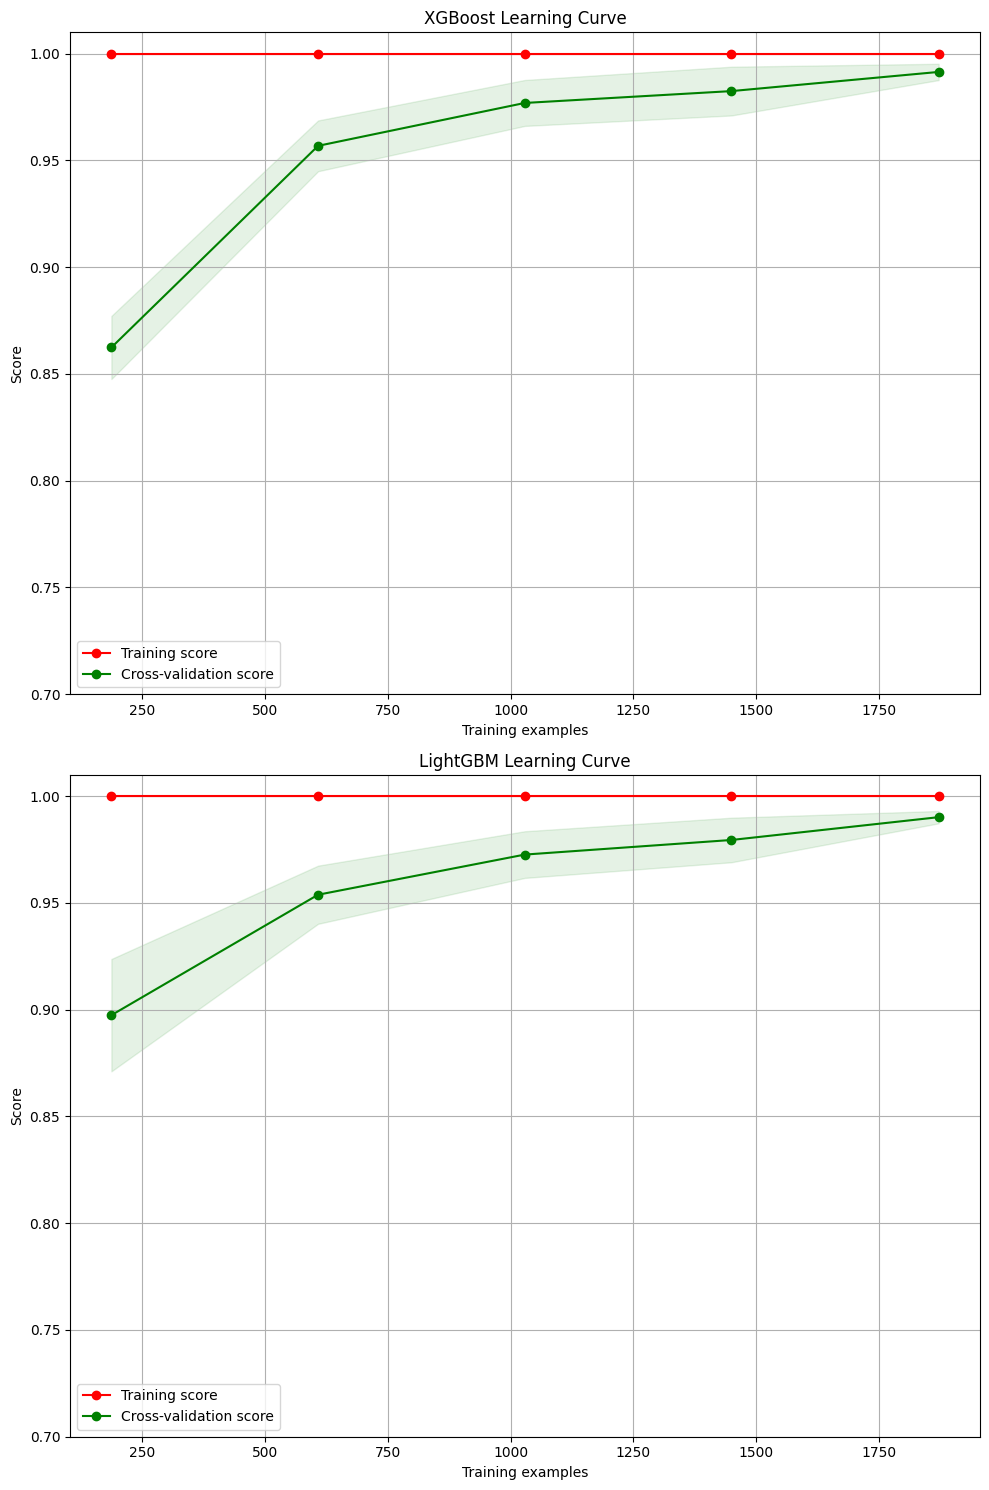

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10, 15))
plot_learning_curve(xgb_model, "XGBoost Learning Curve", X_train, y_train, axes=axes[0], ylim=(0.7, 1.01),
                    cv=5, n_jobs=4)


plot_learning_curve(lgb_model, "LightGBM Learning Curve", X_train, y_train, axes=axes[1], ylim=(0.7, 1.01),
                    cv=5, n_jobs=4)

plt.tight_layout()
plt.show()

****Actual VS Predcited ****

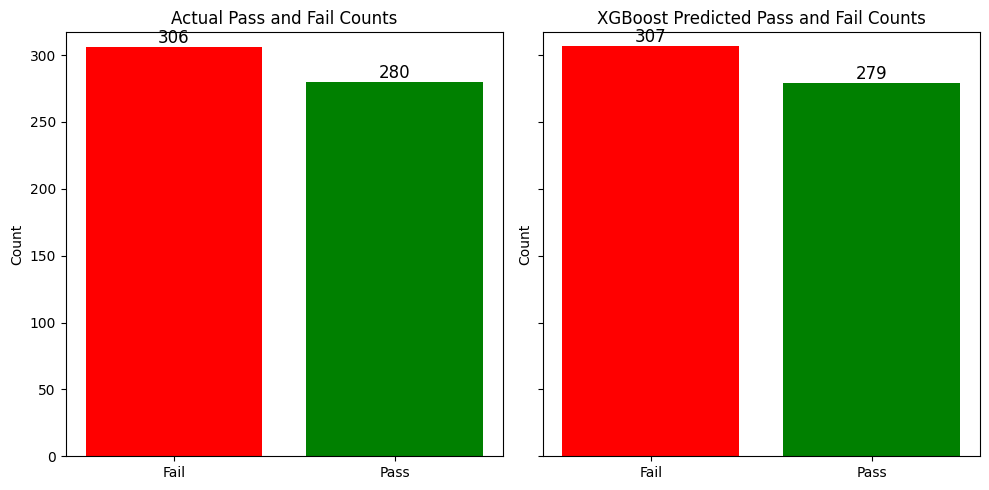

In [14]:
xgb_binary_predictions = np.where(xgb_predictions > 0.5, 1, 0)
actual_pass_fail_counts = [(y_test == 0).sum(), (y_test == 1).sum()]
predicted_pass_fail_counts = [(xgb_binary_predictions == 0).sum(), (xgb_binary_predictions == 1).sum()]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

actual_bars = axes[0].bar(['Fail', 'Pass'], actual_pass_fail_counts, color=['red', 'green'])
axes[0].set_title('Actual Pass and Fail Counts')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, max(actual_pass_fail_counts + predicted_pass_fail_counts) + 10)

predicted_bars = axes[1].bar(['Fail', 'Pass'], predicted_pass_fail_counts, color=['red', 'green'])
axes[1].set_title('XGBoost Predicted Pass and Fail Counts')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, max(actual_pass_fail_counts + predicted_pass_fail_counts) + 10)

for bar, count in zip(actual_bars, actual_pass_fail_counts):
    axes[0].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, count), xytext=(0, 3), 
                     textcoords='offset points', ha='center', fontsize=12)

for bar, count in zip(predicted_bars, predicted_pass_fail_counts):
    axes[1].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, count), xytext=(0, 3), 
                     textcoords='offset points', ha='center', fontsize=12)
    
plt.tight_layout()
plt.show()

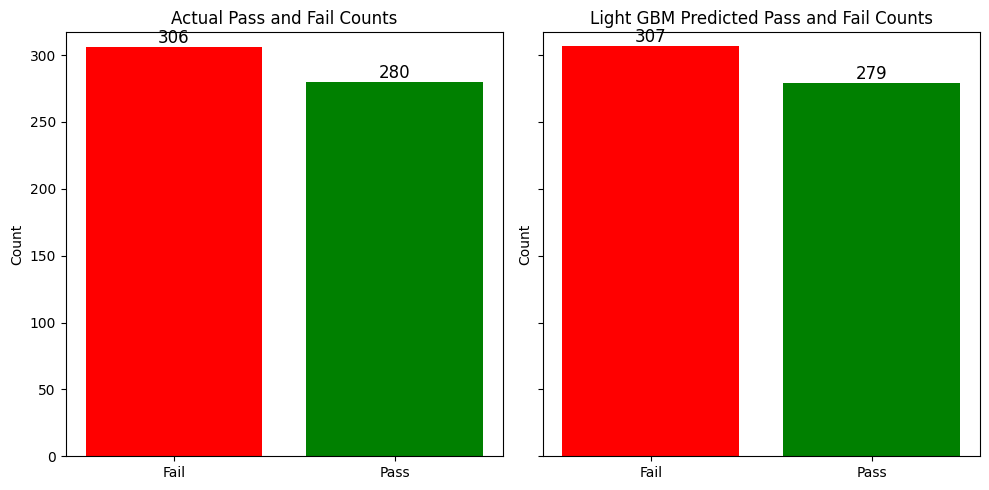

In [15]:
lgb_binary_predictions = np.where(lgb_predictions > 0.5, 1, 0)

actual_pass_fail_counts = [(y_test == 0).sum(), (y_test == 1).sum()]
predicted_pass_fail_counts = [(lgb_binary_predictions == 0).sum(), (xgb_binary_predictions == 1).sum()]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

actual_bars = axes[0].bar(['Fail', 'Pass'], actual_pass_fail_counts, color=['red', 'green'])
axes[0].set_title('Actual Pass and Fail Counts')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, max(actual_pass_fail_counts + predicted_pass_fail_counts) + 10)

predicted_bars = axes[1].bar(['Fail', 'Pass'], predicted_pass_fail_counts, color=['red', 'green'])
axes[1].set_title('Light GBM Predicted Pass and Fail Counts')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, max(actual_pass_fail_counts + predicted_pass_fail_counts) + 10)

for bar, count in zip(actual_bars, actual_pass_fail_counts):
    axes[0].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, count), xytext=(0, 3), 
                     textcoords='offset points', ha='center', fontsize=12)

for bar, count in zip(predicted_bars, predicted_pass_fail_counts):
    axes[1].annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, count), xytext=(0, 3), 
                     textcoords='offset points', ha='center', fontsize=12)
plt.tight_layout()
plt.show()

** Feature Importance Visualization **

Provides insights into which features are most predictive in determining the yield.

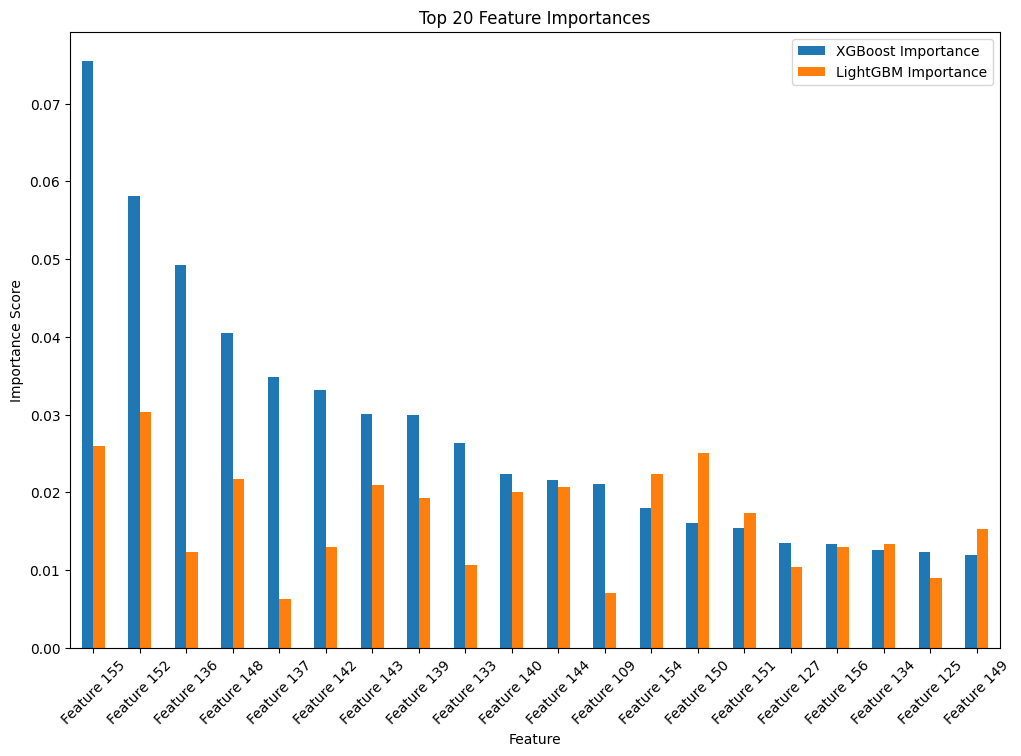

In [16]:

xgb_feature_importances = xgb_model.feature_importances_
lgb_feature_importances = lgb_model.feature_importances_ / np.sum(lgb_model.feature_importances_)  # Normalize LGB feature importances


feature_names = np.array([f'Feature {i}' for i in range(xgb_feature_importances.shape[0])])


df_feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost Importance': xgb_feature_importances,
    'LightGBM Importance': lgb_feature_importances
}).sort_values('XGBoost Importance', ascending=False)


fig, ax = plt.subplots(figsize=(12, 8))
df_feature_importances.head(20).plot(x='Feature', y=['XGBoost Importance', 'LightGBM Importance'], kind='bar', ax=ax)
ax.set_title('Top 20 Feature Importances')
ax.set_ylabel('Importance Score')
ax.set_xlabel('Feature')
plt.xticks(rotation=45)
plt.show()